In [21]:
import sklearn as sk
import scipy as sp
import pandas as pd
import mne
import mne_connectivity
import mne.viz
import numpy as np

In [2]:
#Load a mat file and corresponding metadata
example_mat = sp.io.loadmat('data/20110706/LFP_ch1.mat')
example_time_info = sp.io.loadmat('data/20110706/Movie_start_time.mat')
example_task_info = sp.io.loadmat('data/20110706/Task_info.mat')

example_mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI, Created on: Thu Jul  7 19:42:14 2011',
 '__version__': '1.0',
 '__globals__': [],
 'LFP': array([[-136, -123, -122, ...,  -38,  -20,   -5]], dtype=int16)}

In [3]:
#given a directory, load the LFP files in that directory as channels
data = []
directory = "20100708"

for i in range(128):
    file_num = i + 1
    file_name = "data/" + directory + "/" + "LFP_ch" + str(file_num) + ".mat"
    mat = sp.io.loadmat(file_name)
    data.append(mat["LFP"][0])

data = np.transpose(data)

In [4]:
#given a directory, load the ECoG files in that directory as channels
data = []
directory = "20100615S1_EMT_K2_YasuoNagasaka-ZenasChao_mat_ECoG128-Event3-Eye9"

for i in range(128):
    file_num = i + 1
    file_name = "data/" + directory + "/" + "ECoG_ch" + str(file_num) + ".mat"
    key_name = "ECoGData_ch" + str(file_num)
    mat = sp.io.loadmat(file_name)
    data.append(mat[key_name][0])

data = np.transpose(data)

In [5]:
#perform PCA on the data matrix
from sklearn.decomposition import PCA

pca = PCA(0.9)
pca.fit(data)
num_components = pca.n_components_
pca_matrix = pca.transform(data)
pca_matrix

array([[ -317.13802431,  -205.26757794,   389.46054606, ...,
          140.17674278,   210.14698651,   -71.04987274],
       [ -462.82068471,   -85.87709717,   402.82203493, ...,
          131.62626229,   272.69151251,   -45.40821016],
       [ -604.10382519,    73.70555376,   417.80922876, ...,
          174.76928523,   284.99060855,   -41.23305795],
       ...,
       [-1741.97269689,  -677.39642271,   535.16914288, ...,
         -216.52411908,  -254.89408299,   -55.55312918],
       [-1630.55325302,  -762.99442861,   543.94702849, ...,
         -206.89298803,  -217.58208531,   -91.49007388],
       [-1547.38944362,  -802.68831818,   493.66122506, ...,
         -185.03357834,  -158.70182031,  -108.87621578]])

In [6]:
num_components

53

In [7]:
from sklearn.decomposition import FastICA

#Perfom ICA on the raw data with the recieved number of components.
ica = FastICA(n_components=num_components)
ica.fit(data)
ica_data = ica.transform(data)

In [8]:
#load a mat file into mne
'''
we should be able to directly load a mat file with something like this, but I couldn't get it to work
    example_eeg = mne.io.read_raw_fieldtrip('data/20110706/LFP_ch1.mat', info=None, data_name='LFP')
instead I used this tutorial
https://mne.tools/stable/auto_tutorials/simulation/10_array_objs.html
'''

#create info
n_channels = num_components
sampling_freq = 1000
info = mne.create_info(n_channels, sfreq=sampling_freq)

#load the data from the scipy loaded mat:
#data would be a 2d np array where each row is loaded from one of the mat files as above
ica_data = np.transpose(ica_data)
raw = mne.io.RawArray(ica_data, info)


Creating RawArray with float64 data, n_channels=53, n_times=2166833
    Range : 0 ... 2166832 =      0.000 ...  2166.832 secs
Ready.


In [10]:
#reorganize the ICA matrix into epochs based on trial start times
events = pd.read_csv("data/20100615S1_EMT_K2_YasuoNagasaka-ZenasChao_csv_ECoG128-Event3-Eye9/Event.csv")

cons_matrix = np.transpose(ica_data)

#determine epoch length
min_epoch_len = 9999999
prev_index = 0
for i, event in events.iterrows():
    curr_index = event.EventIndex
    epoch_len = curr_index - prev_index
    prev_index = curr_index
    if epoch_len < min_epoch_len:
        min_epoch_len = int(epoch_len)

print(min_epoch_len)

#construct the final epoch matrix of shape (epochs, channels, samples)
transposed_ica = np.transpose(ica_data)
epoch_matrix = []
for i, event in events.iterrows():
    epoch_matrix.append(np.transpose(transposed_ica[int(event.EventIndex) : int(event.EventIndex) + min_epoch_len]))

#drop last incomplete entry
epoch_matrix = epoch_matrix[:-1]

7050


In [13]:
len(epoch_matrix[0][0])

7050

Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1378 connections
    using t=0.000s..7.049s for estimation (7050 points)
    frequencies: 0.7Hz..500.0Hz (3521 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing cross-spectral density for epoch 1


/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_97531/2271339441.py:10: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), 0 – 7.049 s, baseline off, ~142.6 MB, data loaded,
 '1': 50>, so metadata was not modified.
  con1 = spectral_connectivity_epochs(clip1_epochs, method="pli")


    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    computing cross-spectral density for epoch 21
    comp

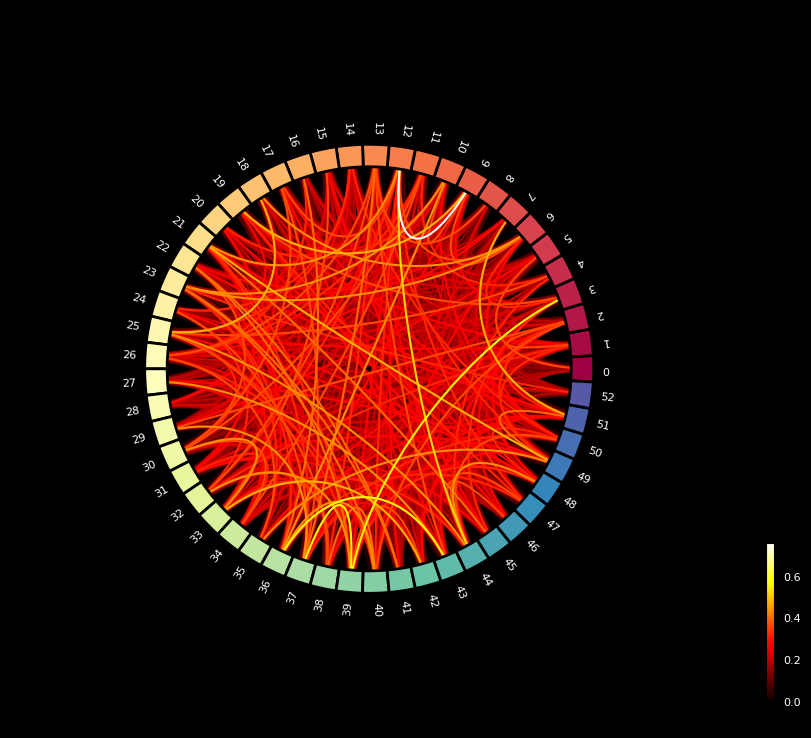

(<Figure size 800x800 with 2 Axes>, <PolarAxes: >)

In [73]:
#connectivity computation
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle
label_names = list(range(53))

#isolate the epochs associated only with the first clip (EventData = 1)
clip1_epochs_matrix = np.array(epoch_matrix)[events[:-1].EventData == 1]
clip1_epochs = mne.EpochsArray(clip1_epochs_matrix, info)

con1 = spectral_connectivity_epochs(clip1_epochs, method="pli")

freq = 50
plot_connectivity_circle(con1.get_data(output="dense")[:,:,freq], label_names)

Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1378 connections
    using t=0.000s..7.049s for estimation (7050 points)
    frequencies: 0.7Hz..500.0Hz (3521 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing cross-spectral density for epoch 1


/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_97531/1714587785.py:5: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), 0 – 7.049 s, baseline off, ~142.6 MB, data loaded,
 '1': 50>, so metadata was not modified.
  con2 = spectral_connectivity_epochs(clip2_epochs, method="pli")


    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    computing cross-spectral density for epoch 21
    comp

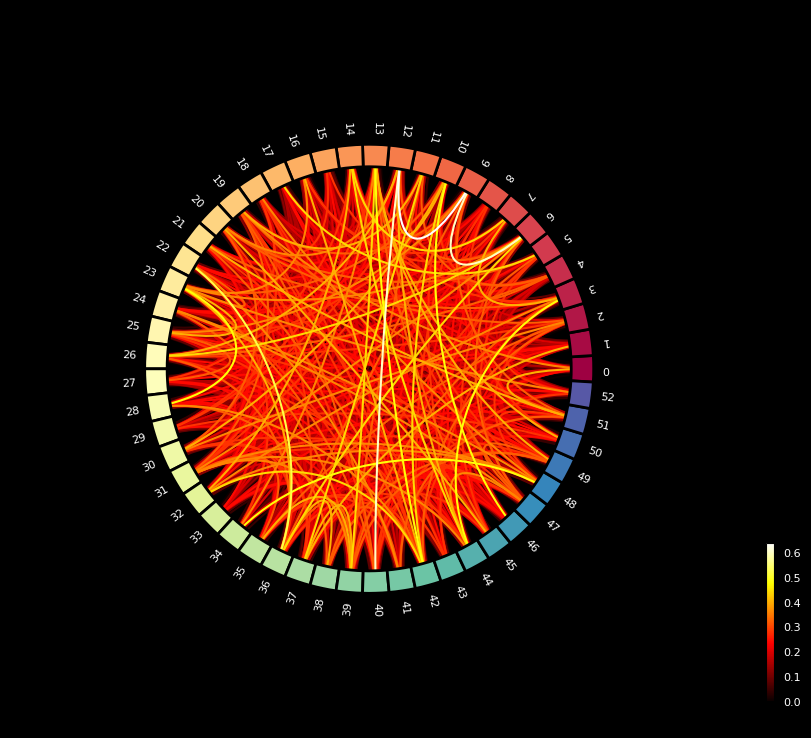

(<Figure size 800x800 with 2 Axes>, <PolarAxes: >)

In [74]:
#isolate the epochs associated only with the second clip (EventData = 2)
clip2_epochs_matrix = np.array(epoch_matrix)[events[:-1].EventData == 2]
clip2_epochs = mne.EpochsArray(clip2_epochs_matrix, info)

con2 = spectral_connectivity_epochs(clip2_epochs, method="pli")

freq = 50
plot_connectivity_circle(con2.get_data(output="dense")[:,:,freq], label_names)

Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1378 connections
    using t=0.000s..7.049s for estimation (7050 points)
    frequencies: 0.7Hz..500.0Hz (3521 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing cross-spectral density for epoch 1


/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_97531/4105125987.py:5: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), 0 – 7.049 s, baseline off, ~142.6 MB, data loaded,
 '1': 50>, so metadata was not modified.
  con3 = spectral_connectivity_epochs(clip3_epochs, method="pli")


    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    computing cross-spectral density for epoch 21
    comp

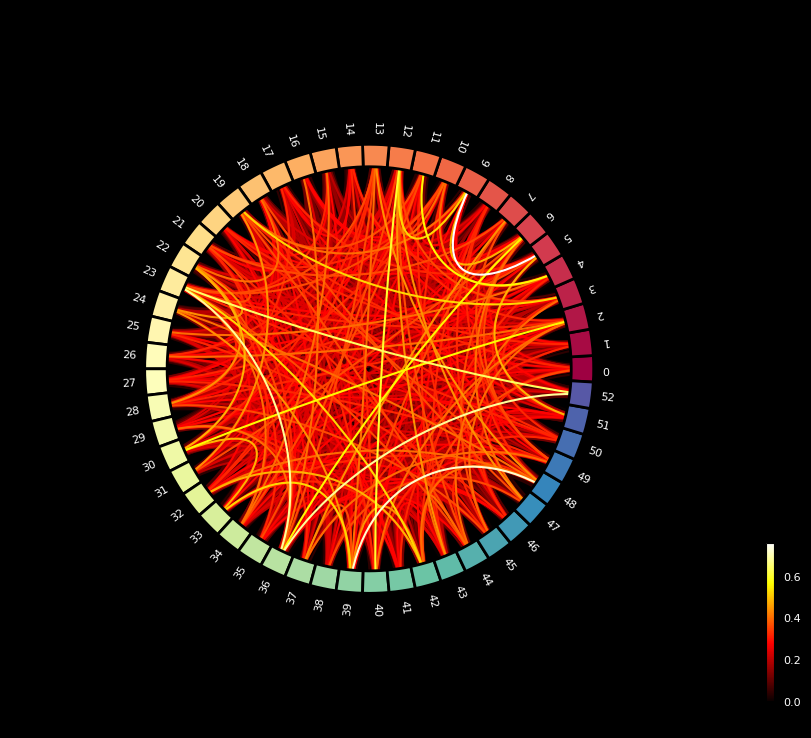

(<Figure size 800x800 with 2 Axes>, <PolarAxes: >)

In [76]:
#isolate the epochs associated only with the second clip (EventData = 3)
clip3_epochs_matrix = np.array(epoch_matrix)[events[:-1].EventData == 3]
clip3_epochs = mne.EpochsArray(clip3_epochs_matrix, info)

con3 = spectral_connectivity_epochs(clip3_epochs, method="pli")

freq = 50
plot_connectivity_circle(con3.get_data(output="dense")[:,:,freq], label_names)